## Install and import

In [1]:
# !pip install -q scikit-learn

In [2]:
import  matplotlib.pyplot as plt
import  numpy as np
import  pandas as pd
from    sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from    sklearn.metrics import mean_absolute_error
from    sklearn.model_selection import train_test_split, GridSearchCV
from    sklearn.impute import KNNImputer, SimpleImputer
from    sklearn.preprocessing import LabelEncoder
import  seaborn as sns
import  warnings

sns.set_theme(style='white')
warnings.filterwarnings('ignore')

In [3]:
# from google.colab import drive
# drive.mount("/content/drive")

# PATH = "drive/MyDrive/30412 Competition"

## Brief analysis

Load and visualize the data to get a better understanding.  
Inspect the target addressing possible concerns, and plot a correlation heatmap to check for collinearity problems.  
I avoid all the bivariate analysis here.

In [4]:
# load train and test data
train_df    = pd.read_csv("30412_train.csv")
test_df     = pd.read_csv("30412_test.csv")

train_df.head(2)

id   price balcony               conditions  construction_year  \
0  10461   60000    True  Buono stato / Abitabile             1980.0   
1  51304  900000     NaN  Buono stato / Abitabile                NaN   

    latitude  longitude  energy_efficiency  expenses  floor garden  \
0  41.901300  12.700000              175.0      30.0    2.0    NaN   
1  41.907017  12.481311                NaN       NaN    3.0    NaN   

   n_bathrooms  elevator  total_floors  n_rooms  proximity_to_center  surface  
0          1.0       NaN           3.0      1.0                  1.0     35.0  
1          1.0       1.0           NaN      3.0                  1.0    131.0

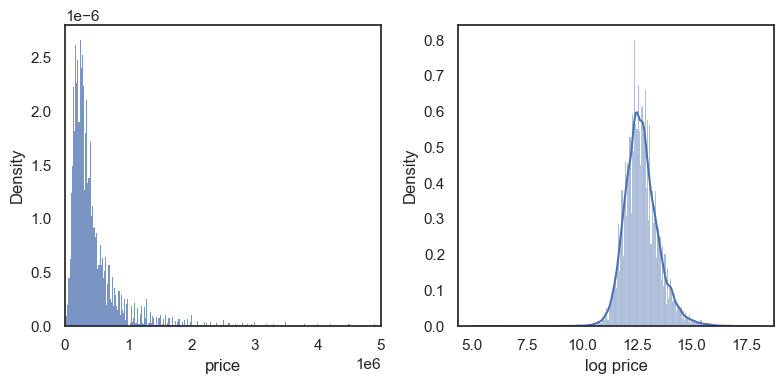

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

price       = train_df["price"]
price_ln    = np.log(price)

# plot histogram for price
sns.histplot(price, stat="density", ax=ax[0])
ax[0].set_xlim(0, 5e6)

# plot histogram for logarithm of price
sns.histplot(price_ln, kde=True, stat="density", ax=ax[1])
ax[1].set_xlabel("log price")

plt.tight_layout()
plt.show()

<Axes: >

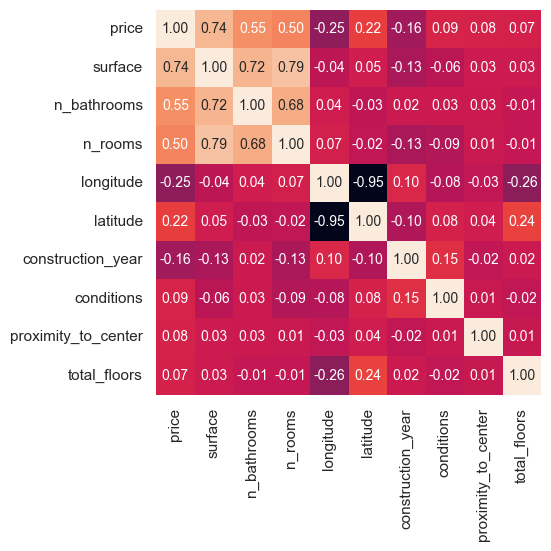

In [6]:
# remove non-numerical entries
correlation_df                  = train_df.dropna()
correlation_df["conditions"]    = LabelEncoder().fit_transform(correlation_df["conditions"])

# compute 10 most correlated variables
cols = abs(correlation_df.corr()).nlargest(10, "price")["price"].index
coef = np.corrcoef(correlation_df[cols].values.T)

# plot heatmap
plt.figure(figsize=(5, 5))
sns.heatmap(
    data        = coef,
    xticklabels = cols.values,
    yticklabels = cols.values,
    cbar        = False,
    square      = True,
    annot       = True,
    fmt         = ".2f",
    annot_kws   = {"size": 10},
)

## Data cleaning

In the cleaning section all the data pre-processing is performed.  
This includes:

- Removing duplicate rows
- Dropping irrelevant features
- Handling outliers and missing values
- Encoding categories

In [7]:
# define reshape series function to comply with sklearn imputers constraints
def reshape_array(array):
    return np.array(array).reshape(-1, 1)

In [8]:
# concatenate train and test data and adjust price
complete_df             = pd.concat([train_df, test_df], ignore_index=True)
complete_df["price"]    = np.log(complete_df["price"])

# count missing values
complete_df.isnull().sum()

id                         0
price                  19788
balcony                22175
conditions              1740
construction_year      19910
latitude                  23
longitude                 23
energy_efficiency      28473
expenses               23125
floor                   2907
garden                 44972
n_bathrooms             3367
elevator               24898
total_floors           26287
n_rooms                  494
proximity_to_center       23
surface                  606
dtype: int64

### Remove duplicates

In [9]:
# check whether there are multiple rows with the same "id"
# if so, remove duplicates
id_count = complete_df["id"].value_counts()
(id_count > 1).sum()

0

### Drop features

In [10]:
# construction year contains a lot of missing values
# some pieces of information about the house status is already given from the conditions feature
# it doesn't make sense to fill it
complete_df.drop(columns="construction_year", inplace=True)

### Fill missing boolean values

In [11]:
# define boolean columns
cols = ["balcony", "garden", "elevator"]

# let's assume that if a boolean variable has a missing value, it means that the house doesn't have that specific feature
# just set the missing values to 0
for c in cols:
    complete_df[c][complete_df[c].isna()] = 0
    complete_df[c] = np.array(complete_df[c], dtype=int)

### Deal with location

After proper manipulation, there are still some missing values, which cannot be computed but just imputed.  
I filled them as follows:

- KNN imputer for the city id, as houses in the same city may share some other features
- Simple mean imputer for the distance from the center

<Axes: xlabel='longitude', ylabel='latitude'>

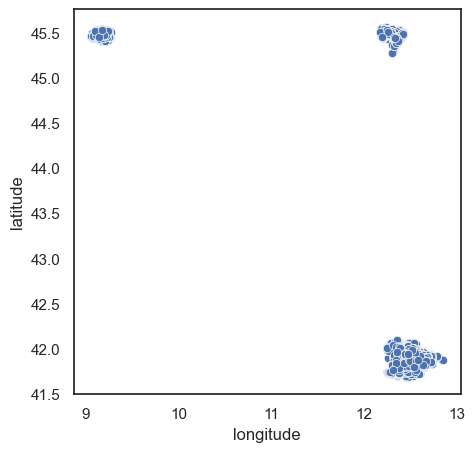

In [12]:
plt.figure(figsize=(5, 5))
# plot location
sns.scatterplot(data=complete_df, x="longitude", y="latitude")

In [13]:
# define mapping from city id to city name and city coordinates
cities_d = {
    0: ["Milan",  (45.467,  9.190)],
    1: ["Venice", (45.262, 12.195)],
    2: ["Rome",   (41.893, 12.483)],
}

# define euclidean distance
def compute_dist(x, p):
    return np.sqrt((x[0]-p[0])**2 + (x[1]-p[1])**2)

In [14]:
# initialize arrays for city id and distance
city_id = np.zeros(len(complete_df))
dist    = np.zeros(len(complete_df))

for idx in range(len(complete_df)):

    # get coordinates
    long    = complete_df["longitude"][idx]
    lat     = complete_df["latitude"][idx]

    # set city id based on coordinates
    if lat > 44:
        if long < 11:
            city_id[idx] = 0
        else:
            city_id[idx] = 1
    else:
        city_id[idx] = 2

    # if either of the coordinates is missing, set both city id and distance to nan
    # these values will be filled later with some imputer
    if np.isnan(lat) or np.isnan(long):
        city_id[idx]    = np.nan
        dist[idx]       = np.nan
        
    # otherwise, compute distance from the center
    else:
        dist[idx] = compute_dist(
            x = (lat, long),
            p = cities_d[city_id[idx]][1]
        )

# fill city id and distance from center
complete_df["city_id"]  = np.array(KNNImputer().fit_transform(reshape_array(city_id)), dtype=int)
complete_df["dist"]     = SimpleImputer(strategy="mean").fit_transform(reshape_array(dist))

In [15]:
# drop original features and keep only the new adjusted ones
for var in (
    "longitude",
    "latitude",
    "proximity_to_center"
):
    complete_df.drop(columns=var, inplace=True)

### Clean and impute categorical features

I filled them as follows:

- Simple mode imputer for both the number of bathrooms and the number of bedrooms
- Median value from the same city for the total number of floors
- Simple mode imputer for the specific floor number
- KNN imputer for the energy efficiency rating, expenses and surface, as similar houses may share also these features
- Simple mode imputer for the conditions

In [16]:
# define imputer
mode_ipt = SimpleImputer(strategy="most_frequent")

# fill number of bathrooms and rooms
complete_df["n_bathrooms"]  = mode_ipt.fit_transform(reshape_array(complete_df["n_bathrooms"]))
complete_df["n_rooms"]      = mode_ipt.fit_transform(reshape_array(complete_df["n_rooms"]))

In [17]:
# compute median of total floors by city
totfloors_median = complete_df.groupby("city_id")["total_floors"].median()

# find missing values and outliers
totfloor_nan = complete_df[complete_df["total_floors"].isna()].index
totfloor_out = complete_df.sort_values(by="total_floors", ascending=False)["total_floors"][:13].index

# fill missing values and outliers with the median value computed above
for idx in np.concatenate((totfloor_nan, totfloor_out)):
    complete_df.loc[idx, "total_floors"] = totfloors_median[complete_df.loc[idx, "city_id"]]

In [18]:
# find floor outliers and set them to null values
floor_out = complete_df.sort_values(by="floor", ascending=False)["floor"][:3].index
complete_df.loc[floor_out, "floor"] = np.nan

# fill specific floor number
floor_new               = mode_ipt.fit_transform(reshape_array(complete_df["floor"]))
complete_df["floor"]    = np.abs(floor_new)

In [19]:
# find energy efficiency outliers and set them to null values
energy_out = complete_df.sort_values(by="energy_efficiency", ascending=False)["energy_efficiency"][:4].index
complete_df.loc[energy_out, "energy_efficiency"] = np.nan

# find expenses outliers and set them to null values
expenses_out = complete_df.sort_values(by="expenses", ascending=False)["expenses"][:18].index
complete_df.loc[expenses_out, "expenses"] = np.nan

# fill energy efficiency, expenses and surface
complete_df[["energy_efficiency", "expenses", "surface"]] = KNNImputer().fit_transform(complete_df[["energy_efficiency", "expenses", "surface"]])

In [20]:
# encode and fill conditions
conditions                  = LabelEncoder().fit_transform(complete_df["conditions"])
complete_df["conditions"]   = mode_ipt.fit_transform((reshape_array(conditions)))

### Data types and checks

In [21]:
# check remaining missing values
complete_df.isna().sum()

id                       0
price                19788
balcony                  0
conditions               0
energy_efficiency        0
expenses                 0
floor                    0
garden                   0
n_bathrooms              0
elevator                 0
total_floors             0
n_rooms                  0
surface                  0
city_id                  0
dist                     0
dtype: int64

In [22]:
# drop id
complete_df.drop(columns="id", inplace=True)

# convert categorical variables to integers
complete_df[["floor", "n_bathrooms", "n_rooms", "total_floors"]] = complete_df[["floor", "n_bathrooms", "n_rooms", "total_floors"]].astype(int)

complete_df.head(2)

price  balcony  conditions  energy_efficiency  expenses  floor  garden  \
0  11.00210        1           0            175.000      30.0      2       0   
1  13.71015        0           0            128.902     113.0      3       0   

   n_bathrooms  elevator  total_floors  n_rooms  surface  city_id      dist  
0            1         0             3        1     35.0        2  0.217159  
1            1         1             4        3    131.0        2  0.014119

## Models

Here I train a Gradient boosting and a Random forest model with grid search cross validation.

In [23]:
# create dummies for the categorical variables 
complete_df = pd.get_dummies(
    data        = complete_df,
    columns     = ["conditions", "floor", "n_bathrooms", "total_floors", "n_rooms", "city_id"],
    drop_first  = True
).astype(float)

In [24]:
# split in train and test
train_df    = complete_df[:46312]
test_df     = complete_df[46312:]

# split train test in train and validation
X_train, X_val, y_train, y_val = train_test_split(
    train_df.drop(columns="price"),
    train_df["price"],
    test_size = 0.2
)

In [25]:
def plot_feat_imp(feat_imp):

    # get 10 highest feature importances and corresponing column names
    feat_top    = np.argsort(abs(feat_imp))[-10:]
    col_names   = [X_train.columns[i] for i in feat_top]

    # plot absolute feature importances
    plt.figure(figsize=(5, 5))
    plt.barh(col_names, feat_imp[feat_top])
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

def round2(x):
    return round(x, 2)

### Gradient boosting

Let's keep underfitting low with a boosting model.

In [26]:
# define grid search parameters for gradient boosting
boost_params = {
    "min_samples_split" : [10, 25],
    "n_estimators"      : [100, 500],
    "subsample"         : [0.5, 0.75, 1],
}

# run grid search with cross validation
boost_cv = GridSearchCV(
    estimator   = GradientBoostingRegressor(),
    param_grid  = boost_params,
    cv          = 5,
    scoring     = "neg_mean_squared_error"
)
boost_cv.fit(X_train, y_train)

print("optimal params\t : {}\ntrain score\t : {} \nvalid score\t : {}".format(
    boost_cv.best_params_, round2(boost_cv.score(X_train, y_train)), round2(boost_cv.score(X_val, y_val))
))

optimal params	 : {'min_samples_split': 25, 'n_estimators': 500, 'subsample': 1}
train score	 : -0.13 
valid score	 : -0.15


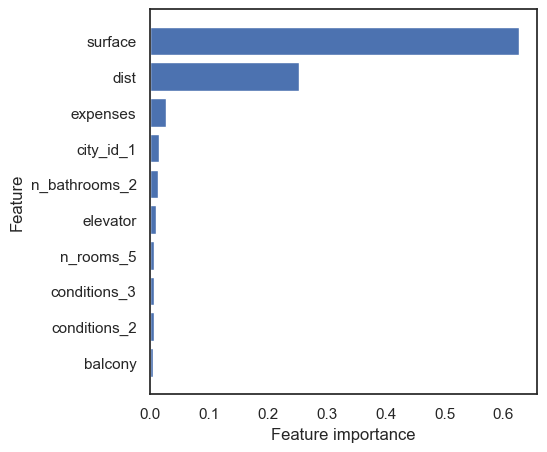

In [27]:
# plot feature importances
feat_imp_boost = boost_cv.best_estimator_.feature_importances_
plot_feat_imp(feat_imp_boost)

### Random forest

Reduce the variance with a bagging model.

In [28]:
# define grid search parameters for gradient foresting
forest_params = {
    "max_features"      : [10, 20],
    "min_samples_split" : [5, 10, 20],
    "n_estimators"      : [100, 500],
}

# run grid search with cross validation
forest_cv = GridSearchCV(
    estimator   = RandomForestRegressor(),
    param_grid  = forest_params,
    cv          = 5,
    scoring     = "neg_mean_squared_error"
)
forest_cv.fit(X_train, y_train)

print("optimal params\t : {}\ntrain score\t : {} \nvalid score\t : {}".format(
    forest_cv.best_params_, round2(forest_cv.score(X_train, y_train)), round2(forest_cv.score(X_val, y_val))
))

optimal params	 : {'max_features': 20, 'min_samples_split': 5, 'n_estimators': 500}
train score	 : -0.04 
valid score	 : -0.14


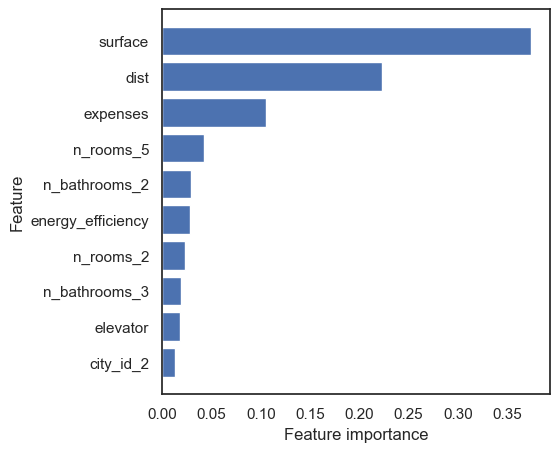

In [29]:
# plot feature importances
feat_imp_forest = forest_cv.best_estimator_.feature_importances_
plot_feat_imp(feat_imp_forest)

## Evaluation metrics

In the evaluation section I compare the performance of the two models using mae and manually produce an ensemble method based on them.  
Although the feature importances are similar, I hope the ensemble could pick up different patterns in the data.

In [30]:
# get best gradient boosting model and predictions 
boost   = boost_cv.best_estimator_
y_boost = boost.predict(X_val)

# get best random forest model and predictions
forest      = forest_cv.best_estimator_
y_forest    = forest.predict(X_val)

print("gradient boost mae\t : {}\nforest mae\t\t : {}".format(
    round2(mean_absolute_error(y_val, y_boost)), round2(mean_absolute_error(y_val, y_forest))
))

gradient boost mae	 : 0.26
forest mae		 : 0.24


In [31]:
# manually produce an ensemble method
alpha = np.arange(0, 1.1, 0.1)

# initialize best values
best_mae    = 100
best_a      = 0

# loop to find the actual best mae and alpha
for a in alpha:
    mae = mean_absolute_error(y_val, a*y_boost + (1-a)*y_forest)
    
    if mae < best_mae:
        best_mae    = mae
        best_alpha  = a

print("best mae\t : {}\nbest alpha\t : {}".format(round2(best_mae), best_alpha))

best mae	 : 0.24
best alpha	 : 0.0


In [32]:
# get ensemble prediction
# to produce the actual test prediction this result should be exponentiated
y = best_alpha*y_boost + (1-best_alpha)*y_forest